In [1]:
# python imports
import os
import time
import functools

import numpy as np
from scipy import stats
from scipy.stats import uniform, norm, t as tdist, ttest_ind


In [2]:
# setup graphs
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib import rc

plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100;

# numpy print format
np.set_printoptions(linewidth=120, precision=4, suppress=False, formatter={'float': '{:5.3e}'.format})

In [3]:
# local imports
import util.tests as tests
import util.dwdb_reader as io
import util.func as f


DpawsTools not found. Fall back to scipy


In [4]:
small_value = 1e-300
tvla_thrd = 4.5 * np.sqrt(2)

PROJECT_ROOT_DIR=os.getcwd()
tracenum = 50*1000
step = 50
sample_start = 120 # 30  100    # 40
sample_end =   130 # 50  500    # 180
rlen = sample_end - sample_start

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(IMAGES_PATH): os.makedirs(IMAGES_PATH)

LOG_DIR = os.path.join(PROJECT_ROOT_DIR, "log")
if not os.path.exists(LOG_DIR): os.makedirs(LOG_DIR)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load traces and predictions

In [5]:
print("Reading traces")
# dsr = io.dwdb_reader(r'DPAD_FvR.Traces/RawTraces.dwdb', r'DPAD_FvR.Traces')
# dsr = io.dwdb_reader(r'DPAD_AES2.Traces/RawTraces_new.dwdb', r'DPAD_AES2.Traces')
dsr = io.dwdb_reader(r'RawTraces_new.dwdb', r'.')
data_batch, meta_batch = dsr.read_batch(tracenum, sample_start, sample_end)
print("Done")

print("Processing data and meta")
# converting data to numpy matrix
data_np = np.asarray(data_batch)

#processing of classifiers
meta_prep = [m['other'].split() for m in meta_batch]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers_np = np.asarray(classifiers)

print("Done")

data_np.shape, classifiers_np.shape

Reading traces
Done
Processing data and meta
Done


((50000L, 10L), (50000L,))

## Sanity check. Make sure it leaks

In [6]:
atrace = np.mean(data_np[:10], axis=0)
tt = tests.fvr_ttest(data_np, classifiers_np)


<IPython.core.display.Javascript object>


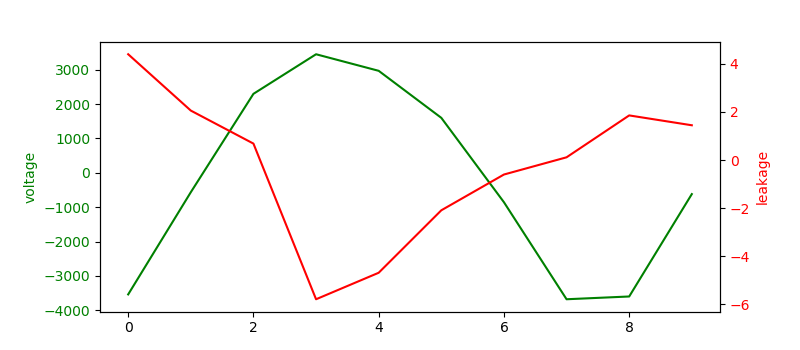

In [7]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('voltage', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.set_ylabel('leakage', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.plot(atrace, color='g') # signal
ax2.plot(tt, color='r')     # leak
plt.show()

## Evolution

In [8]:
tstat_evo = []
xx = np.arange(step, tracenum+1, step)
for x in xx:
    tt = tests.fvr_ttest(data_np[:x], classifiers_np[:x])
    tstat_evo.append(tt)
tstat_evo = np.array(tstat_evo)
tstat_evo = np.abs(tstat_evo) # comment out for intermediates

# Max leakage info
tr_num, max_leak_pt = np.unravel_index(np.argmax(tstat_evo), tstat_evo.shape)
max_leak_val, max_leak_at = tstat_evo[tr_num, max_leak_pt], tr_num*step
max_leak_pv = tdist.sf(max_leak_val, max_leak_at)
print("Max leak at point: {}, value: {:5.3e} (pv: {:5.3e}), trace: {}".format(
    max_leak_pt, max_leak_val, max_leak_pv, max_leak_at))

Max leak at point: 3, value: 6.327e+00 (pv: 1.264e-10), trace: 43650


<IPython.core.display.Javascript object>


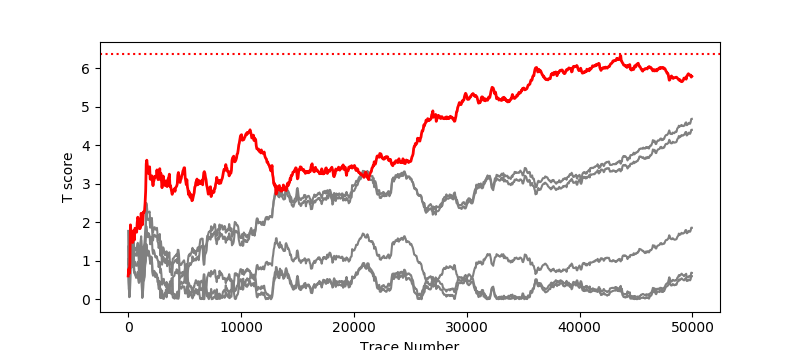

In [10]:
step_num, pt_num = np.shape(tstat_evo)

fig = plt.figure()
plt.ylabel('T score')
plt.xlabel('Trace Number')
plt.axhline(y=tvla_thrd, color='r', linestyle=':')

x_axis = np.arange(step_num) * step

# Plot leak history for each 2th point 
for j in range(0, pt_num, 2):
    plk = tstat_evo.T[j]
    plt.plot(x_axis, plk, linewidth=1.5, linestyle='-', color = 'grey', zorder = j)

# Max leak point
mlpt = max_leak_pt
plt.plot(x_axis, tstat_evo[:, mlpt], linewidth=2, linestyle='-', color = 'r', zorder=255)
plt.show()

## Bootstrapping

In [11]:
boots_list = [11, 21, 51]  # boots
boot_step = 25   # step
upper_bnd = 1000 #tracenum
ld_stat = stats.uniform
ld_cdf = ld_stat().cdf

t_full_per_step = []   # cannot be numpy array due to different lengths per boot
tp_full_per_step = []  # cannot be numpy array due to different lengths per boot
ksp_per_step = []
for rangenum in range(boot_step, upper_bnd+1, boot_step):
    # Run all boots for a step
    t_full_per_boot, tp_full_per_boot, ksp_per_boot = [], [], []
    for j, boots in enumerate(boots_list):
        start = time.time()
        crossed_ml = 0
        t_full = np.empty((boots, rlen), dtype=np.float64)
        tp_full = np.empty_like(t_full)
        ks_full = np.empty_like(tp_full[0])
        boot_idxs = np.random.randint(rangenum, size=(boots, rangenum))
        for i, bi in enumerate(boot_idxs):
            t_full[i] = tests.fvr_ttest(data_np[bi], classifiers_np[bi]) # calc tt and keep it
            tp_full[i] = tdist.sf(t_full[i], rangenum)                   # convert tt to pv and keep pv
        # Post process boot for the step
        tp_full[np.where(np.isnan(tp_full))] = small_value
        tp_full[np.where(tp_full < small_value)] = small_value
        # Run ks-test for p-values
        for i in range(rlen):
            d, ks_full[i] = f.kstest(tp_full.T[i], ld_cdf)               # throw away d, keep pv
        t_full_per_boot.append(t_full)
        tp_full_per_boot.append(tp_full)
        ksp_per_boot.append(ks_full)
        lfound = 'SAME LEAK ACHIEVED!' if ks_full[max_leak_pt] < max_leak_pv else ''
        print("Trace count: {}, boots: {} are done in {} ({})".format(
            rangenum, boots, time.time() - start, lfound))
    t_full_per_step.append(t_full_per_boot)
    tp_full_per_step.append(tp_full_per_boot)
    ksp_per_step.append(ksp_per_boot)
ksp_per_step = np.asarray(ksp_per_step)


Trace count: 25, boots: 11 are done in 0.00699996948242 ()
Trace count: 25, boots: 21 are done in 0.0110001564026 ()
Trace count: 25, boots: 51 are done in 0.0160000324249 ()
Trace count: 50, boots: 11 are done in 0.00600004196167 ()
Trace count: 50, boots: 21 are done in 0.00800013542175 ()
Trace count: 50, boots: 51 are done in 0.0179998874664 ()
Trace count: 75, boots: 11 are done in 0.00600004196167 ()
Trace count: 75, boots: 21 are done in 0.00999999046326 ()
Trace count: 75, boots: 51 are done in 0.0160000324249 ()
Trace count: 100, boots: 11 are done in 0.00600004196167 ()
Trace count: 100, boots: 21 are done in 0.0090000629425 ()
Trace count: 100, boots: 51 are done in 0.0159997940063 ()
Trace count: 125, boots: 11 are done in 0.00600004196167 ()
Trace count: 125, boots: 21 are done in 0.0090000629425 ()
Trace count: 125, boots: 51 are done in 0.0179998874664 ()
Trace count: 150, boots: 11 are done in 0.00699996948242 ()
Trace count: 150, boots: 21 are done in 0.0090000629425 (

# Bootstrapping vizualization

<IPython.core.display.Javascript object>


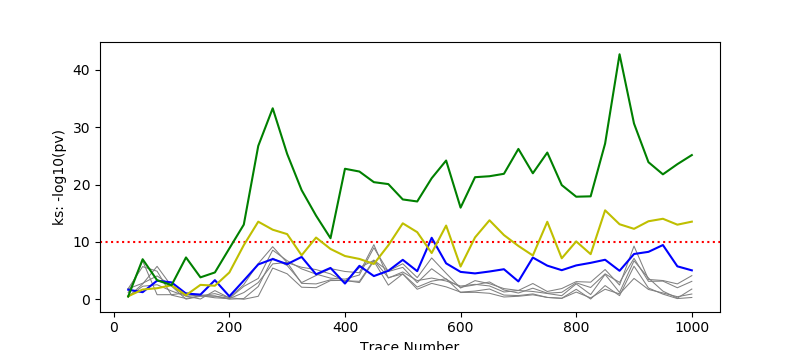

In [12]:
mlpi =  max_leak_pt # 15

# Prepare data
pt_num, step_num = np.shape(ksp_per_step[:, 0].T)

x_axis = (np.arange(step_num) + 1) * boot_step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('ks: -log10(pv)')
# tvla_high threshold converted to pv scale
tvla_thrd_pvlog = -np.log10(max_leak_pv) # 200 is approx n
plt.axhline(y=tvla_thrd_pvlog, color='r', linestyle=':')

# Plot boot evolution for each 2nd point of 1st boot in the list (for comparison)
boot_idx = 0
plot_evo = ksp_per_step[:, boot_idx].T
for j in range(0, pt_num, 2):
    kspl = -np.log10(plot_evo[j])
    plt.plot(x_axis, kspl, linewidth=0.75, color = 'grey', zorder = j)

# and hist for max leaky point per boot
cpalette = ['b', 'y', 'g', 'r', 'c']
for i in range(ksp_per_step.shape[1]):
    maxkslpv = -np.log10(ksp_per_step[:, i].T[mlpi])  # boots_list[0]
    plt.plot(x_axis, maxkslpv, linewidth=1.5, color = cpalette[i%5], zorder=255)

plt.show()
# plot_evo.shape, x_axis.shape

## Outcome

- Real threshold is 4.5 * sqrt(2) is similar to twice as much traces (TVLA requires two runs). 
- It means that leak is not occasional
- The threshold get converted to t-distribution p-value to compare with ks-test p-value
- We can compare (number_of_traces1) required to reach the point of the real leakage with (number_of_boots) * (number_of_traces2). Where number_of_traces1 is the number for the regular TVLA process and (number_of_traces2) is the number required for bootstrapping.
  - For example TVLA requires 43.5k traces to reach 6 sigma, bootstrapping requires 225 traces * 50 boots = 11250, i.e. bootstrapping reaches the same leak *4 times faster*

# Below are cells to debug code snippets

## Debugging ks-test 

In [ ]:
# Find out whether it follows the uniform distribution
ksp_per_step2 = np.zeros_like(tp_full_per_step[:,1])

for s, bps in enumerate(tp_full_per_step):          # step
    bpsr = bps.T                                    # -> (pt, boot)
    start = time.time()
    print('{}: Step {} ...'.format(bpsr.shape, s))
    for i, ptbt in enumerate(bpsr):
        d, kpv = f.kstest(ptbt, ld_cdf)
        ksp_per_step2[s, i] = kpv
    print("Done in {}".format(time.time() - start))


## Debugging distributions for kstest

In [ ]:

mpi = max_leak_pt # 6 178
si = 2

# bpvs = t_full_per_step[si].T  # t
bpvs = tp_full_per_step[si].T   # t-pv

kpvs = []
leak_dist = stats.uniform
# leak_dist = stats.norm
for j in range(0, len(bpvs)):
    bp = bpvs[j]
    d, pv = f.kstest(bp, leak_dist().cdf)
    l, s = leak_dist.fit(bp)      # loc and scale of the dist at the point
    leaking = pv < 0.05           # 3 sigma assurance the point is leaking (non uniform)
    kpvs.append([d, pv, l, s, leaking])
d, pv = f.kstest(bpvs[mpi], leak_dist().cdf)
l, s = leak_dist.fit(bpvs[mpi])  # loc and scale of the dist at the max leak point
leaking = pv < 0.05
kpvs.append([d, pv, l, s, leaking])

# print("d, pv, l, s, leaking")
# print(np.array(kpvs))
    
# norm_cdf = norm(loc=0, scale=1).cdf
# dt, pv  = stats.kstest(bpvs, norm_cdf)

fig = plt.figure()
plt.xlabel('Boot Number')
for j in range(0, len(bpvs), 20):
    plt.plot(bpvs[j], color = 'grey', linewidth=0.5, zorder = j)

plt.plot(bpvs[mpi], color = 'r', linewidth=2, zorder=255)
plt.show()

## Debugging at some boot

In [ ]:
%%script false    # This line is to skip this cell as a whole in the real run. Comment to debug a boot step
# rp_full_per_step = []  # rpv
# t_full_per_step = []   # t
# tp_full_per_step = []  # tpv

pb = 0
bootidx = 15

pb = 0
pi = 19 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0

plot_evo = t_full_per_step[:,bootidx,:,pi].reshape(-1, 3, 256)

x_axis = (np.arange(len(plot_evo)) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('T score')

hw_num = plot_evo.shape[2]
for j in range(0, hw_num, 4):
    mtt = plot_evo[:, byte_idx[pb], j]
    plt.plot(x_axis, mtt, linewidth=0.5, color = 'grey', zorder = j)
plt.plot(x_axis, plot_evo[:, byte_idx[pb], key_idx[pb]], linewidth=1, color = 'r', zorder=255)

plt.show()


## Getting familiar with tests 

In [ ]:
ud = uniform(loc=0, scale=1)
for i in range(3):
    udrv = ud.rvs(size=1000)
    dk, kpv = stats.kstest(udrv, 'uniform') # H0 - data is uniform
    non_uniform = kpv < 0.05
    print(dk, kpv, non_uniform)

In [ ]:
x_100 = norm.rvs(loc=10, scale=1, size=100)
nd = norm(loc=0, scale=1)
for i in range(3):
    ndrv = nd.rvs(size=100)
    dn, npv = stats.kstest(ndrv, 'norm') # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

In [ ]:
nd_cdf = norm(loc=10, scale=1).cdf
for i in range(3):
    ndrv = norm.rvs(loc=10, scale=1, size=100)
    dn, npv = stats.kstest(ndrv, nd_cdf) # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)